<a href="https://colab.research.google.com/github/kickassakash/coding-for-fun/blob/master/Tutorial_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Canny Edge Detector Implementation

##Overview of the Canny Edge Detection Algorithm
###The Canny edge detection algorithm is a multi-step process that detects edges in an image while reducing noise. The main steps involved in the Canny edge detection process are:

###Gaussian Smoothing: The image is smoothed using a Gaussian filter to reduce noise and unwanted details. This is important as it helps to prevent false edge detection.

###Gradient Calculation: The gradients of the image are computed using convolution with Sobel filters. This step calculates the intensity of the edges and their orientations.

###Non-Maximum Suppression: This step refines the edge detection results by suppressing all gradient values that are not considered to be edge points. It involves checking the gradient direction and only keeping the maximum gradient values in the direction of the edge.

###Double Thresholding: The non-maximum suppressed image is thresholded to classify pixels into strong, weak, and non-edges. Strong edges are those above a high threshold, while weak edges fall between the low and high thresholds.

###Edge Tracking by Hysteresis: In this final step, weak edges are only kept if they are connected to strong edges. This helps in suppressing false edges while retaining the true edges.

##Implementation
###We define the canny_edge_detector() function, which takes an image and parameters for Gaussian smoothing, low threshold, and high threshold.
###The function applies the aforementioned steps to detect edges in the input image.
###We also load an example image (kodim19.png) and convert it to grayscale for processing.
##Comparison with OpenCV's Canny Edge Detector
###We compare our custom implementation with OpenCV Canny edge detector using the same input image. The results from both methods are displayed side by side for visual comparison.

##Results
###The left image shows the results of our custom Canny edge detector, while the right image displays the output from OpenCV implementation. This allows us to evaluate the effectiveness and accuracy of our custom algorithm.

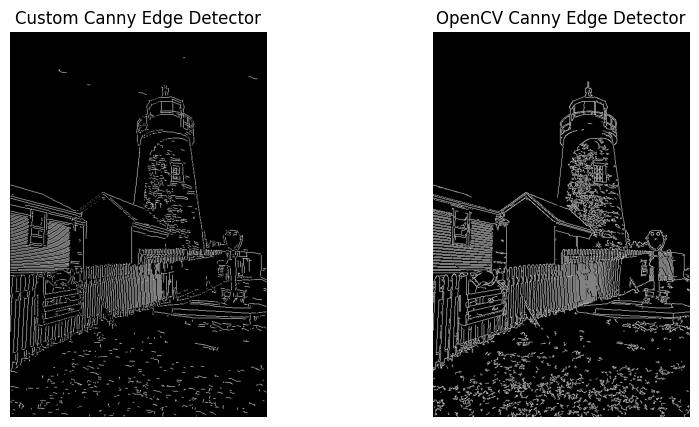

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# Define Sobel filters
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])


def canny_edge_detector(image, sigma=1.4, low_threshold=20, high_threshold=50):
    # Step 1: Gaussian filter for noise reduction
    smoothed = gaussian_filter(image, sigma=sigma)

    # Step 2: Calculate gradients using convolution
    gradient_x = cv2.filter2D(smoothed, cv2.CV_64F, sobel_x)
    gradient_y = cv2.filter2D(smoothed, cv2.CV_64F, sobel_y)

    gradient_magnitude = np.hypot(gradient_x, gradient_y)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * (180 / np.pi) % 180

    # Step 3: Non-maximum suppression
    # Comparing the neighbors
    nms = np.zeros_like(gradient_magnitude, dtype=np.float64)
    height, width = gradient_magnitude.shape

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            angle = gradient_direction[y, x]
            if (0 <= angle < 45):
                neighbors = [gradient_magnitude[y, x - 1], gradient_magnitude[y, x + 1]]
            elif (45 <= angle < 90):
                neighbors = [gradient_magnitude[y - 1, x + 1], gradient_magnitude[y + 1, x - 1]]
            elif (90 <= angle < 135):
                neighbors = [gradient_magnitude[y - 1, x], gradient_magnitude[y + 1, x]]
            else:
                neighbors = [gradient_magnitude[y - 1, x - 1], gradient_magnitude[y + 1, x + 1]]
            #if maxima then keep else set to 0
            if gradient_magnitude[y, x] >= max(neighbors):
                nms[y, x] = gradient_magnitude[y, x]

    # Step 4: Double thresholding
    #Strong Edges
    strong_edges = (nms > high_threshold)
    #weak Edges
    weak_edges = (nms >= low_threshold) & (nms <= high_threshold)


    thresholded_edges = np.zeros_like(nms, dtype=np.uint8)
    thresholded_edges[strong_edges] = 2  # Strong edges
    thresholded_edges[weak_edges] = 1  # Weak edges

    # Step 5: Edge tracking by hysteresis
    height, width = thresholded_edges.shape
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if thresholded_edges[y, x] == 1:  # If it's a weak edge
                # Check if it is connected to a strong edge
                if 2 in thresholded_edges[y - 1:y + 2, x - 1:x + 2]:
                    thresholded_edges[y, x] = 2  # Link it to strong edge
                else:
                    thresholded_edges[y, x] = 0  # Suppress it

    return thresholded_edges


# Load an image
image = cv2.imread('/content/drive/MyDrive/tutorial_5/kodim19.png', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
if image is None:
    raise ValueError("Image not found or unable to load.")

# Ensure the image is float64 for processing
image = image.astype(np.float64)

# Implement the Canny edge detector from scratch
custom_edges = canny_edge_detector(image)

# Use OpenCV's Canny edge detector, Lower Threshold = 100, Higher Threshhold = 200
opencv_edges = cv2.Canny(image.astype(np.uint8), 100, 200)

# Plotting results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Custom Canny Edge Detector')
plt.imshow(custom_edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('OpenCV Canny Edge Detector')
plt.imshow(opencv_edges, cmap='gray')
plt.axis('off')

plt.show()


#Harris Corner Detector Implementation
In this notebook, we implement the Harris corner detection algorithm from scratch using Python, alongside a comparison with OpenCV's built-in Harris corner detector.

##Overview of the Harris Corner Detection Algorithm
The Harris corner detection algorithm is used to identify corners (or interest points) in an image. Corners are useful in various computer vision tasks, such as object recognition and tracking. The main steps of the Harris corner detection process are as follows:

Image Conversion: The input image is converted to grayscale to simplify the analysis, as color information is not necessary for corner detection.

Gradient Calculation: The gradients of the image are computed using the Sobel operator. This step involves calculating the horizontal and vertical gradients,
𝐼
𝑥
I
x
​
  and
𝐼
𝑦
I
y
​
 , which represent the changes in intensity in both directions.

Products of Derivatives: The products of the gradients are calculated:

𝐼𝑥𝑥=𝐼𝑥2

𝐼𝑥𝑦=𝐼𝑥⋅𝐼𝑦

𝐼𝑦𝑦=𝐼𝑦2

Gaussian Filtering: A Gaussian filter is applied to smooth the products of the derivatives. This step helps to reduce noise and improve the stability of the corner response.

Harris Response Calculation: The Harris response
R is computed using the determinant and trace of the matrix formed by the products of the gradients:

𝑅
=
det
(
𝑀
)
−
𝑘
⋅
trace
(
𝑀
)
^2 =  λ1 *  λ2 - k( λ1 + λ2 )^2
where
𝑀 is the matrix containing
𝐼𝑥𝑥, 𝐼𝑥𝑦, and 𝐼𝑦𝑦 and
k is a constant parameter that affects sensitivity.

Thresholding: Corners are identified by thresholding the Harris response
R. Only the points with a response value greater than a specified threshold are marked as corners.

The values of corner response R can be interpreted as follows:

• Flat regions: λ1 and  λ2 are small,  R is positive and small.

• Edges: λ1 > > λ2 or vice versa, R < 0

• Corners:λ1 and λ2 are large, λ1~λ2 and ,R is large.

Implementation
We define the harris_corner_detector function, which takes an image and parameters for the sensitivity factor
k and the threshold for corner detection.
The function applies the steps mentioned above to detect corners in the input image.
We load an example image (geometric.png) for processing.

##Results
The image shows the results of our custom Harris corner detector

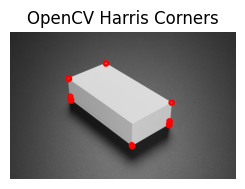

In [ ]:
def draw_circles(image, corners):
    # Convert to grayscale for displaying purposes
    output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Find coordinates of corners
    y_coords, x_coords = np.where(corners > 0)

    # Draw circles on the original image
    for x, y in zip(x_coords, y_coords):
        cv2.circle(output_image, (x, y), radius=5, color=(255, 0, 0), thickness=2)

    return output_image

# Load the image
image = cv2.imread('/content/drive/MyDrive/tutorial_5/Geometric.png')  # Replace with your image path

# OpenCV Harris corner detector
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)

#blockSize specifies defines the size of the neighborhood considered around each pixel to calculate the corner response (2X2)
#ksize is the aperture parameter for the Sobel operator used to compute the image derivatives. In this case, ksize=3 specifies a
#3x3 Sobel filter for calculating the gradients in the x and y directions.
#k is typically between 0.04 to 0.06 in det ( 𝑀 ) − 𝑘 ⋅ trace ( 𝑀 ) 2
opencv_corners = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.04)

# Result thresholding
# The corner points, which appear as small bright spots in the opencv_corners image, are enlarged.
#This makes the corners more prominent and easier to visualize and locate.
opencv_corners = cv2.dilate(opencv_corners, None)  # Dilate to enhance corner points

#opencv_corners is the thresholded image, which is reassigned to opencv_corners. Now, opencv_corners contains a binary image where:
#Pixels with intensity values greater than 0.01 * opencv_corners.max() are set to 255 (white).
#Pixels with intensity values below this threshold are set to 0 (black).
_, opencv_corners = cv2.threshold(opencv_corners, 0.01 * opencv_corners.max(), 255, 0)

# Draw corners on the original image
opencv_image_with_corners = draw_circles(image, opencv_corners)

plt.subplot(1, 2, 2)
plt.title('OpenCV Harris Corners')
plt.imshow(opencv_image_with_corners)
plt.axis('off')

plt.show()

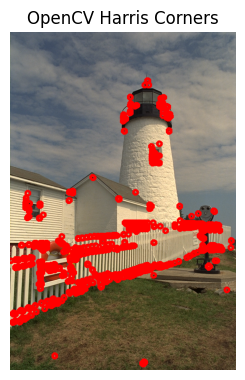

In [ ]:
# Load the image
image = cv2.imread('/content/drive/MyDrive/tutorial_5/kodim19.png')  # Replace with your image path

# OpenCV Harris corner detector
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)
opencv_corners = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.04)

# Result thresholding
opencv_corners = cv2.dilate(opencv_corners, None)  # Dilate to enhance corner points
_, opencv_corners = cv2.threshold(opencv_corners, 0.01 * opencv_corners.max(), 255, 0)

# Draw corners on the original image
opencv_image_with_corners = draw_circles(image, opencv_corners)

plt.subplot(1, 2, 2)
plt.title('OpenCV Harris Corners')
plt.imshow(opencv_image_with_corners)
plt.axis('off')

plt.show()

#SIFT Keypoint Detection using OpenCV
In this notebook, we implement the Scale-Invariant Feature Transform (SIFT) algorithm to detect keypoints in images using OpenCV.

##Overview of SIFT
SIFT is a robust feature detection algorithm used to identify and describe local features in images. It is particularly effective for matching keypoints across different images, even under changes in scale, rotation, and illumination. The main steps involved in SIFT keypoint detection are as follows:

Image Conversion: The input image is converted to grayscale, which simplifies the computation since color information is not necessary for keypoint detection.

SIFT Initialization: We initialize the SIFT detector using OpenCV's built-in cv2.SIFT_create() function.

It includes various parameters to customize the behavior of the detector.

###Parameters:

nfeatures:	The number of best features to retain. The features are ranked by their scores (measured in SIFT algorithm as the local contrast)

nOctaveLayers:	The number of layers in each octave. 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

contrastThreshold:	The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector.

Note
The contrast threshold will be divided by nOctaveLayers when the filtering is applied. When nOctaveLayers is set to default and if you want to use the value used in D. Lowe paper, 0.03, set this argument to 0.09.

edgeThreshold:	The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less features are filtered out (more features are retained).

sigma:	The sigma of the Gaussian applied to the input image at the octave #0. If your image is captured with a weak camera with soft lenses, you might want to reduce the number.

###Keypoint and Descriptor Detection:
The SIFT detector identifies keypoints and computes descriptors for each keypoint. Descriptors are vector representations of the keypoints that capture the surrounding image region's features.

cv2.detectAndCompute()

####Returns:
keypoints: This is a list of keypoints found in the image. Each keypoint contains information such as location (x, y), size, angle, response strength, and octave information.

descriptors: These are the feature vectors (descriptors) associated with each keypoint. Each descriptor is a vector of 128 values.

###Drawing Keypoints:
 Detected keypoints are visually represented on the image. Each keypoint is drawn as a circle with a specific orientation and size, indicating its location and scale.

cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: This draws the keypoints with additional information such as the size and orientation of the keypoints (i.e., a circle with an arrow representing the orientation).

####The keypoints are drawn as circles, where:
#####The center of the circle represents the keypoint’s location.

#####The size of the circle is proportional to the scale of the keypoint.

#####The arrow drawn inside the circle represents the keypoint’s orientation.

##Implementation
We define the sift_keypoints function, which takes the image path as input.
The function loads the image, converts it to grayscale, and applies the SIFT algorithm to detect keypoints.
The results are displayed using the cv2_imshow function from the google.colab.patches module, which is suitable for displaying images in Colab.

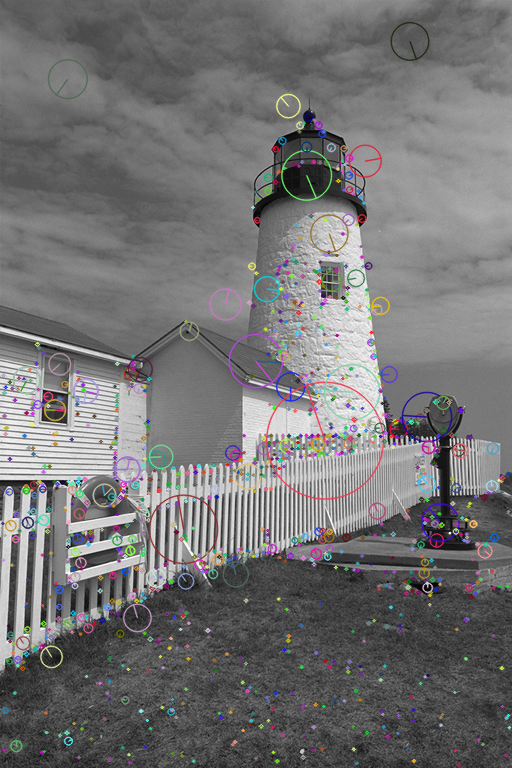

In [ ]:
from google.colab.patches import cv2_imshow
# SIFT Keypoint Detection using OpenCV
def sift_keypoints(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    #nfeatures: The number of best features to retain. The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    #nOctaveLayers: The number of layers in each octave. 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.
    #contrastThreshold: The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector.
    #edgeThreshold: The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less features are filtered out (more features are retained).
    #sigma: The sigma of the Gaussian applied to the input image at the octave #0. If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    #The SIFT detector identifies keypoints and computes descriptors for each keypoint. Descriptors are vector representations of the keypoints that capture the surrounding image region's features.
    kp, des = sift.detectAndCompute(gray,None)

    # Draw keypoints
    #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: This draws the keypoints with additional information such as the size and orientation of the keypoints (i.e., a circle with an arrow representing the orientation).
    img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv2_imshow(img)

# Demonstrate SIFT keypoints detection
sift_keypoints('/content/drive/MyDrive/tutorial_5/kodim19.png')

#Pedestrian Detection using HOG
Here, we implement pedestrian detection using the Histogram of Oriented Gradients (HOG) algorithm with OpenCV. The HOG descriptor is widely used for object detection, particularly for detecting pedestrians in images.

##Overview of HOG Descriptor
The HOG descriptor works by extracting features based on the distribution of intensity gradients and edge directions in localized portions of an image. The key steps involved in pedestrian detection using HOG are:

Image Loading: The input image is read using OpenCV.

HOG Descriptor Initialization: We create an instance of the HOG descriptor and set the pre-trained Support Vector Machine (SVM) detector specifically for pedestrian detection. This detector is trained on a large dataset of images containing pedestrians.

Pedestrian Detection: The detectMultiScale method is called to identify pedestrians in the image. It returns bounding boxes around detected pedestrians. The parameters used include:

##winStride: The step size for sliding the detection window. A smaller value may improve detection accuracy.

##padding: Additional pixels added around the detection window to account for scale variation.

##scale: The factor by which the image size is reduced in each step, affecting the detection scale.

##hitThreshold: The threshold for filtering out weak detections.

##groupThreshold: Controls the number of detections to group into a single detection.

Drawing Detected Pedestrians: Rectangles are drawn around the detected pedestrians to visualize the results.

Image Display: The resulting image with detected pedestrians is displayed using matplotlib. The image is converted from BGR (OpenCV's default format) to RGB for accurate color representation.

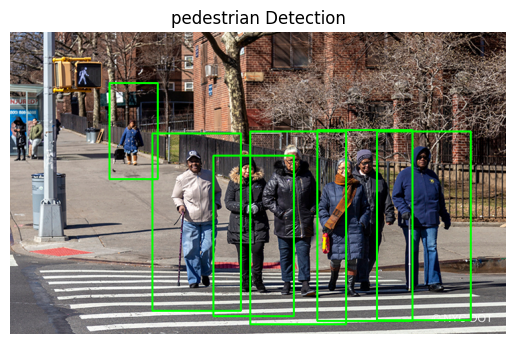

In [ ]:
def pedestrian_detection(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Initialize HOG Descriptor with default parameters for pedestrian detection
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    # Detect pedestrians
    #winStride: The step size for sliding the detection window. A smaller value may improve detection accuracy.
    #padding: The padding parameter specifies the amount of padding added around the sliding window during the detection process
    #scale: The factor by which the image size is reduced in each step, affecting the detection scale, making it possible to detect images varying sizes
    #hitThreshold: The threshold for filtering out weak detections.
    #groupThreshold: Controls the number of detections to group into a single detection.
    boxes, _ = hog.detectMultiScale(img, winStride=(1, 1), padding=(0,0), scale = 1.03, hitThreshold=0, groupThreshold=4)

    # Draw rectangles around detected pedestrians
    for (x, y, w, h) in boxes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Convert the image from BGR to RGB format for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis
    plt.title('pedestrian Detection')
    plt.show()

# Demonstrate pedestrian detection
pedestrian_detection('/content/drive/MyDrive/tutorial_5/pedestrian.png')

#Texture Classification using Local Binary Patterns (LBP)
Here, we implement texture classification using Local Binary Patterns (LBP) in combination with histogram comparison. LBP is a powerful feature extraction technique widely used in image processing for texture analysis.

##Overview of Local Binary Patterns (LBP)
LBP is a texture descriptor that works by comparing each pixel with its neighboring pixels. The resulting binary pattern is converted to a decimal value, which is then used to build a histogram that represents the texture of the image. The key steps involved in this notebook are:

###Loading Textures: We load a set of predefined textures (brick, gravel, grass) from the skimage library.

###Computing LBP Histogram: The compute_lbp_histogram function calculates the LBP for the given image, builds a histogram with 256 bins, and normalizes it. The histogram represents the frequency of each LBP value in the image.

###Classifying a New Patch:A new texture patch (e.g., grass_test.png) is read and its LBP histogram is computed. The classify_patch function uses the Chi-square distance to compare the new patch's histogram with the histograms of the loaded textures, identifying the closest match.

###Visualization: The histograms and LBP images for the predefined textures are displayed. The new input patch along with its LBP histogram is visualized to evaluate the classification result.

###1. Importing Required Libraries
The following libraries are imported:

cv2: For reading images and processing them with OpenCV.

numpy: For array operations and mathematical functions.

matplotlib.pyplot: For visualizing images and histograms.

skimage: For built-in texture datasets and LBP feature extraction.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.feature import local_binary_pattern
from skimage.metrics import structural_similarity as ssim

### 2. Loading Texture Datasets
We load sample images of brick, gravel, and grass using the built-in textures from the skimage.data module. These textures are used to compute the LBP features for classification.

In [ ]:
# Load textures
textures = {
    "brick": data.brick(),
    "gravel": data.gravel(),
    "grass": data.grass()
}

###3. Computing LBP Features Using Scikit-Image Implementation
The local_binary_pattern() function from skimage.feature computes the LBP for the textures using the following parameters:

RADIUS: The radius of the circular LBP pattern (set to 1).

N_POINTS: The number of circularly symmetric neighbors (8).

METHOD: The LBP pattern type (using the default method here).

We define the compute_lbp_histogram() function to calculate the LBP of an image and return its normalized histogram.

In [ ]:
# Constants for LBP
# RADIUS is the radius of the circle (in pixels) that defines the neighborhood around each pixel where the N_POINTS are sampled
RADIUS = 1
# N_POINTS defines the number of sampling points to consider around a central pixel. These points are placed evenly around a circle of a specified radius
N_POINTS = 8

#This specifies the method or type of Local Binary Pattern to compute. Common methods include:
#'default': Basic LBP. It assigns a binary value based on whether each surrounding pixel is greater or less than the center pixel.
#'ror' (Rotation Invariant LBP): This makes the LBP code rotation-invariant by rotating the binary pattern into its minimum value.
#'uniform': Uniform LBP patterns are patterns with at most two transitions between 0 and 1 in the binary sequence. This reduces the number of patterns and enhances robustness.
#'var': This returns the variance of the local binary patterns, which can capture more texture information.
METHOD = 'default'  # Using uniform LBP

# Function to compute LBP histogram
def compute_lbp_histogram(image):
    #using sklearn lbp function
    lbp = local_binary_pattern(image, N_POINTS, RADIUS, METHOD)
    (hist, _) = np.histogram(lbp, bins=np.arange(257), range=(0, 256))  # 256 bins
    # (hist, _) = np.histogram(lbp, bins=np.arange(0, N_POINTS + 3), range=(0, N_POINTS + 2))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize the histogram
    return hist, lbp

###4. Classifying a New Input Patch
A new input patch (grass_test.png) is loaded, and its LBP histogram is computed. A Chi-square distance metric is used to classify the new patch by comparing its LBP histogram with the histograms of the three textures.

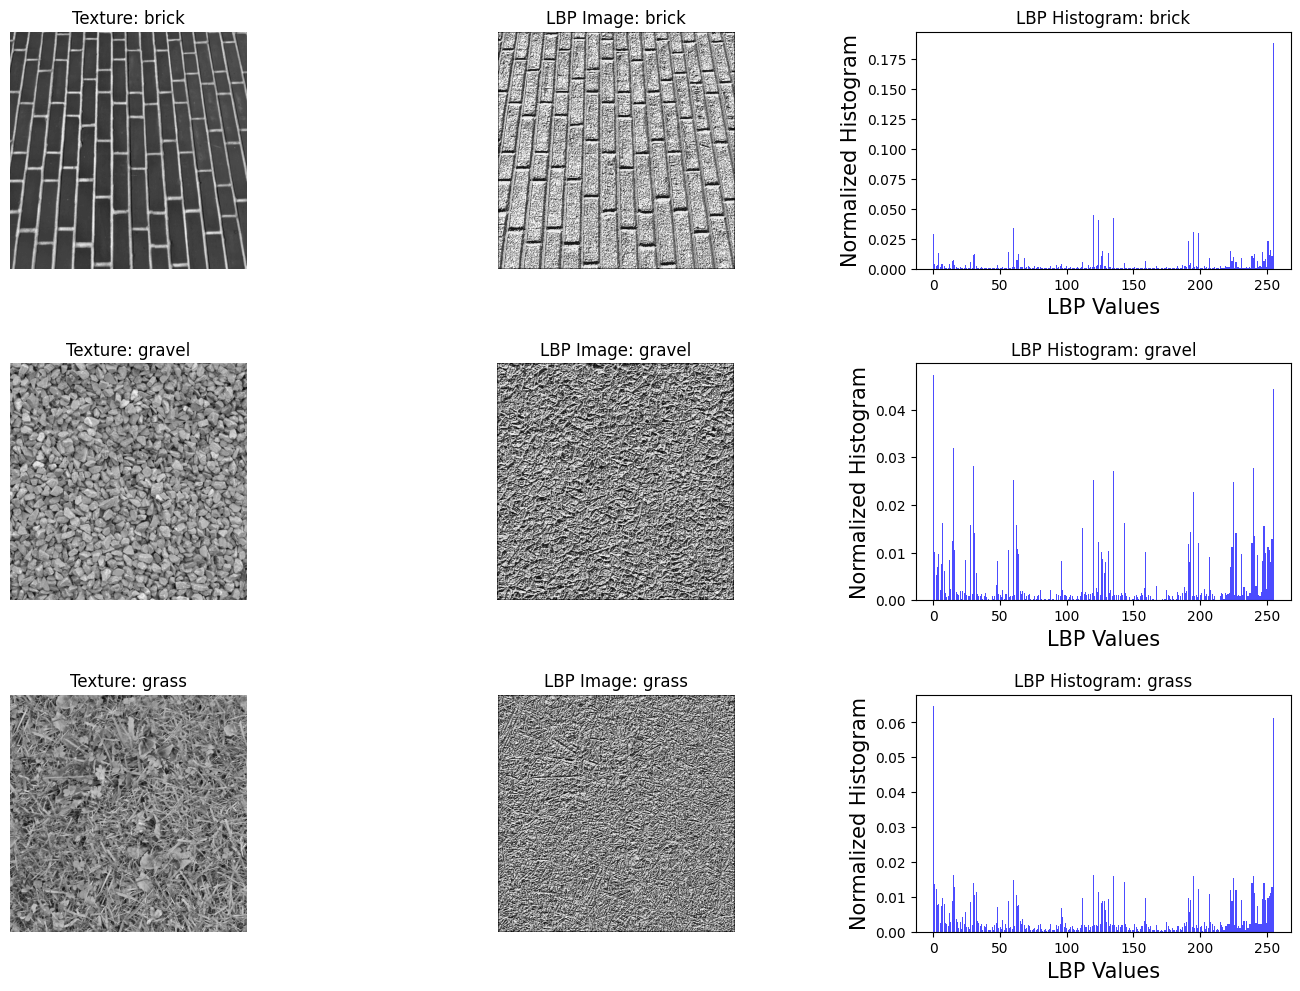

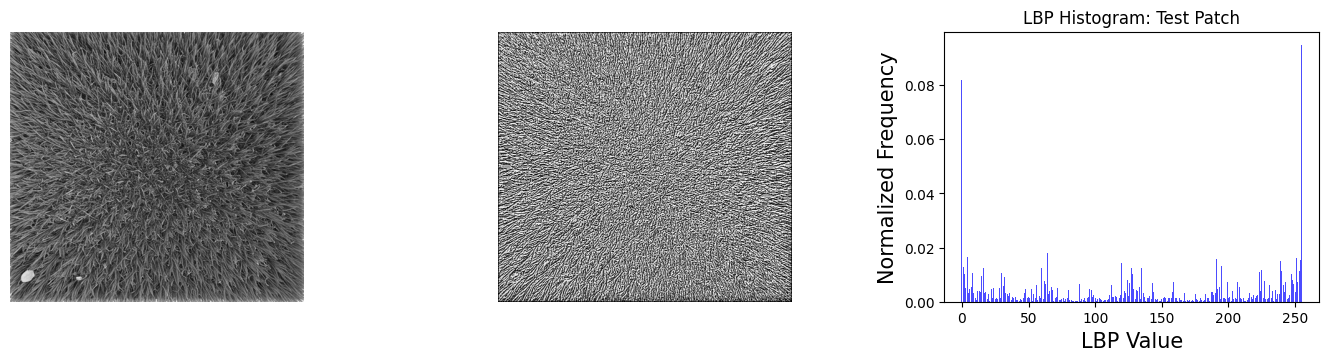

The new patch is classified as: grass


In [ ]:
# Compute LBP histograms and images for the textures
lbp_histograms = {}
lbp_images = {}
for name, image in textures.items():
    hist, lbp_image = compute_lbp_histogram(image)
    lbp_histograms[name] = hist
    lbp_images[name] = lbp_image

# Visualization
plt.figure(figsize=(15, 10))

# Plot the textures and LBP histograms
for i, (name, image) in enumerate(textures.items()):
    # Texture images
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Texture: {name}')
    plt.axis('off')

    # LBP images
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(lbp_images[name], cmap='gray')
    plt.title(f'LBP Image: {name}')
    plt.axis('off')

    # LBP histograms
    plt.subplot(3, 3, 3*i + 3)
    plt.bar(range(256), lbp_histograms[name], color='blue', alpha=0.7)
    plt.title(f'LBP Histogram: {name}')
    plt.xlabel('LBP Values', size=15)
    plt.ylabel('Normalized Histogram', size=15)
    # plt.xticks(range(256))
    plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)
plt.show()

# New patch
new_patch = cv2.imread("/content/drive/MyDrive/tutorial_5/grass_test.png", cv2.IMREAD_GRAYSCALE) # Replace this with the new input patch
new_patch_hist, new_patch_lbp = compute_lbp_histogram(new_patch)
# plt.bar(range(N_POINTS + 2), new_patch_hist, color='blue', alpha=0.7)
plt.figure(figsize=(15, 3))
plt.subplot(1,3,1)
plt.imshow(new_patch, cmap='gray')
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(new_patch_lbp, cmap='gray')
plt.axis("off")
plt.subplot(1,3,3)
plt.bar(range(256), new_patch_hist, color='blue', alpha=0.7)
plt.title('LBP Histogram: Test Patch')
plt.xlabel('LBP Value', size=15)
plt.ylabel('Normalized Frequency', size=15)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)

plt.show()
# Function to classify the new patch based on LBP histogram
def classify_patch(new_hist, class_histograms):
    distances = {}
    for class_name, hist in class_histograms.items():
        # Using Chi-square distance
        #This is an element-wise operation where the squared difference between corresponding histogram bins is divided by the sum of the two bins.
        distance = np.sum(((new_hist - hist) ** 2) / (new_hist + hist + 1e-6))
        distances[class_name] = distance
    # Return the class with the smallest distance
    return min(distances, key=distances.get)


# Classify the new patch
predicted_class = classify_patch(new_patch_hist, lbp_histograms)

# Print results
print(f"The new patch is classified as: {predicted_class}")


###5. LBP Implementation from Scratch
The code also demonstrates how to compute LBP manually by iterating through each pixel and comparing it with its 8-connected neighbors. The pattern is then stored as an 8-bit binary number representing the LBP.

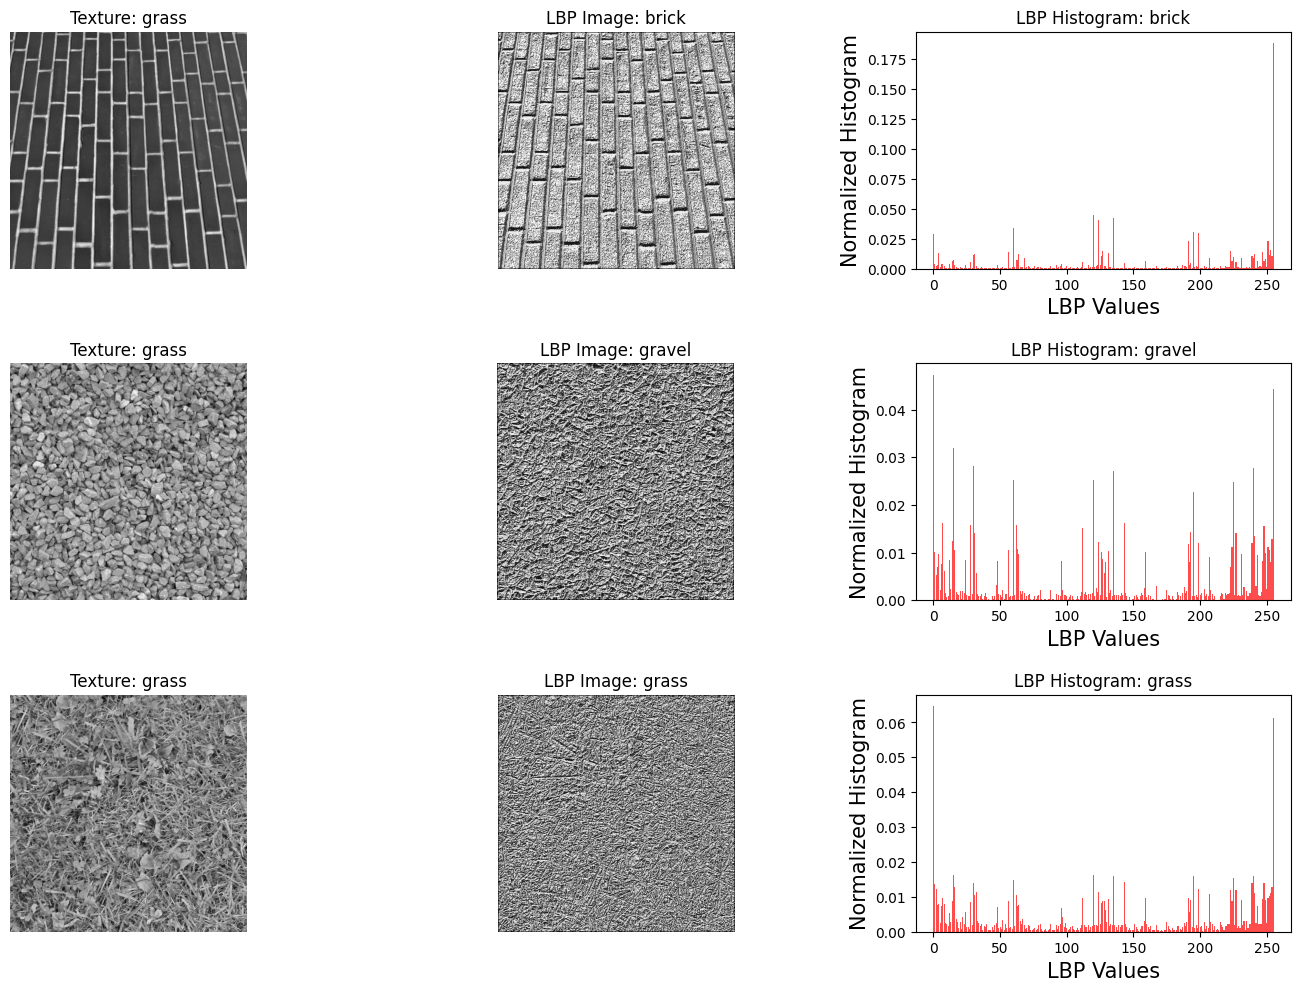

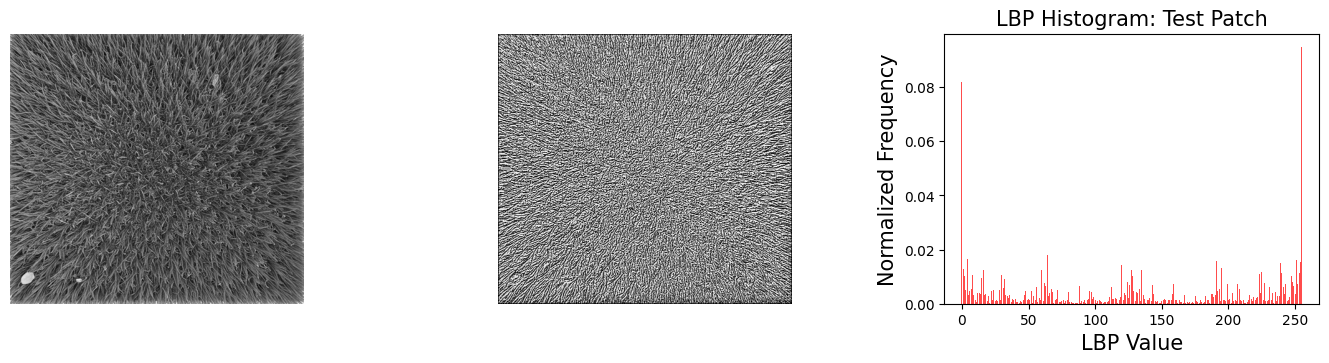

The new patch is classified as: grass


In [ ]:
# Function to compute LBP from scratch using 8-connected neighborhood
def compute_lbp(image):
    lbp_image = np.zeros_like(image, dtype=np.uint8)
    rows, cols = image.shape

    # Iterate over each pixel in the image (excluding the border pixels)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            center_pixel = image[i, j]
            binary_pattern = 0

            # 8-connected neighborhood
            neighbors = [
                image[i-1, j-1],  # Top-left
                image[i-1, j],    # Top
                image[i-1, j+1],  # Top-right
                image[i, j+1],    # Right
                image[i+1, j+1],  # Bottom-right
                image[i+1, j],    # Bottom
                image[i+1, j-1],  # Bottom-left
                image[i, j-1]     # Left
            ]

            for p in range(8):
                if neighbors[p] >= center_pixel:
                    #If p = 0, 1 << (7 - 0) means shifting 1 to position 7, resulting in the binary number 10000000
                    binary_pattern |= (1 << (7 - p))  # Set the appropriate bit

            lbp_image[i, j] = binary_pattern

    return lbp_image

# Function to compute LBP histogram
def compute_lbp_histogram(image):
    lbp = compute_lbp(image)
    (hist, _) = np.histogram(lbp, bins=np.arange(257), range=(0, 256))  # 256 bins
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize the histogram
    return hist, lbp

# Prepare dataset for classification
histograms = {}
plt.figure(figsize=(15, 10))
for i, (label, image) in enumerate(textures.items()):
    hist, lbp = compute_lbp_histogram(image)
    histograms[label] = hist
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Texture: {name}')
    plt.axis('off')

    # LBP images
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(lbp, cmap='gray')
    plt.title(f'LBP Image: {label}')
    plt.axis('off')

    # LBP histograms
    plt.subplot(3, 3, 3*i + 3)
    plt.bar(range(256), hist, color='red', alpha=0.7)
    plt.title(f'LBP Histogram: {label}')
    plt.xlabel('LBP Values', size=15)
    plt.ylabel('Normalized Histogram', size=15)
    # plt.xticks(range(256))
    plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)
plt.show()

# New input patch (replace this with your actual patch)
new_patch = cv2.imread("/content/drive/MyDrive/tutorial_5/grass_test.png", cv2.IMREAD_GRAYSCALE) # Replace this with the new input patch
new_patch_hist, new_patch_lbp = compute_lbp_histogram(new_patch)

# Function to calculate the distance between two histograms
def histogram_distance(hist_a, hist_b):
    return np.sum(((hist_a - hist_b) ** 2) / (hist_a + hist_b + 1e-6))  # Chi-squared distance



# Visualization of LBP Histogram
plt.figure(figsize=(15, 3))

# Plot the new input patch
plt.subplot(1,3,1)
plt.imshow(new_patch, cmap='gray')
plt.axis("off")
# Plot the LBP image of the test patch
plt.subplot(1,3,2)
plt.imshow(new_patch_lbp, cmap='gray')
plt.axis("off")
# Plot the LBP Histogram with 256 bins
plt.subplot(1,3,3)
plt.bar(range(256), new_patch_hist, color='red', alpha=0.7)
plt.title('LBP Histogram: Test Patch', size=15)
plt.xlabel('LBP Value', size=15)
plt.ylabel('Normalized Frequency', size=15)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)

plt.show()
# Classify based on minimum distance
min_distance = float('inf')
predicted_class = None

for label, hist in histograms.items():
    distance = histogram_distance(new_patch_hist, hist)
    if distance < min_distance:
        min_distance = distance
        predicted_class = label

# Print the predicted class
print(f"The new patch is classified as: {predicted_class}")